In [ ]:
#@title Run to Install dependencies for canvas and other imports (20 s)
!pip install -q ipycanvas ipywidgets
import os 
if not os.path.exists('/content/digit-classifiers/notebook'):
  !git clone https://github.com/robbxi/digit-classifiers.git
%cd /content/digit-classifiers/notebook


from google.colab import output
output.enable_custom_widget_manager()

from ipycanvas import Canvas
from ipywidgets import VBox, HBox, Button, Dropdown, Output
import numpy as np
from PIL import Image
import torch
import utils
from IPython.display import clear_output, display
import asyncio

In [ ]:
#@title Interactive Demo
#@markdown Draw a digit in the box below, select a classifier, and click predict.

from IPython.display import display, HTML
import ipywidgets as widgets
import numpy as np
from PIL import Image
import torch
import utils
import io
import base64

# Create the HTML canvas with JavaScript
canvas_html = """
<div id="canvas-container">
    <canvas id="drawCanvas" width="280" height="280" 
            style="border: 1px solid #ccc; cursor: crosshair; background: black;">
    </canvas>
</div>

<script>
const canvas = document.getElementById('drawCanvas');
const ctx = canvas.getContext('2d');
let drawing = false;

ctx.fillStyle = 'black';
ctx.fillRect(0, 0, 280, 280);
ctx.strokeStyle = 'white';
ctx.lineWidth = 15;
ctx.lineCap = 'round';
ctx.lineJoin = 'round';

canvas.addEventListener('mousedown', startDrawing);
canvas.addEventListener('mousemove', draw);
canvas.addEventListener('mouseup', stopDrawing);
canvas.addEventListener('mouseout', stopDrawing);

// Touch events for mobile
canvas.addEventListener('touchstart', (e) => {
    e.preventDefault();
    const touch = e.touches[0];
    const rect = canvas.getBoundingClientRect();
    const x = touch.clientX - rect.left;
    const y = touch.clientY - rect.top;
    ctx.beginPath();
    ctx.moveTo(x, y);
    drawing = true;
});

canvas.addEventListener('touchmove', (e) => {
    e.preventDefault();
    if (!drawing) return;
    const touch = e.touches[0];
    const rect = canvas.getBoundingClientRect();
    const x = touch.clientX - rect.left;
    const y = touch.clientY - rect.top;
    ctx.lineTo(x, y);
    ctx.stroke();
});

canvas.addEventListener('touchend', (e) => {
    e.preventDefault();
    drawing = false;
});

function startDrawing(e) {
    drawing = true;
    const rect = canvas.getBoundingClientRect();
    ctx.beginPath();
    ctx.moveTo(e.clientX - rect.left, e.clientY - rect.top);
}

function draw(e) {
    if (!drawing) return;
    const rect = canvas.getBoundingClientRect();
    ctx.lineTo(e.clientX - rect.left, e.clientY - rect.top);
    ctx.stroke();
}

function stopDrawing() {
    drawing = false;
}

function clearCanvas() {
    ctx.fillStyle = 'black';
    ctx.fillRect(0, 0, 280, 280);
}

function getCanvasData() {
    return canvas.toDataURL('image/png');
}
</script>
"""

display(HTML(canvas_html))

# Model dropdown
model_dropdown = widgets.Dropdown(
    options=['KNN', 'Bayes', 'Linear', 'Multi-layer', 'CNN', 'All'],
    value='KNN',
    description='Model:'
)

# Output widget
output_widget = widgets.Output()

# Buttons
clear_button = widgets.Button(description='Clear Canvas')
predict_button = widgets.Button(description='Predict')
clear_output_button = widgets.Button(description='Clear Output')

def clear_canvas(b):
    display(HTML("<script>clearCanvas();</script>"))

def get_canvas_image():
    """Get image from canvas via JavaScript"""
    from google.colab import output as colab_output
    canvas_data = colab_output.eval_js('getCanvasData()')
    
    # Decode base64 image
    img_data = canvas_data.split(',')[1]
    img_bytes = base64.b64decode(img_data)
    img = Image.open(io.BytesIO(img_bytes))
    
    # Convert to grayscale and resize
    img_gray = img.convert('L')
    img_resized = img_gray.resize((28, 28), Image.LANCZOS)
    img_array = np.array(img_resized) / 255.0
    
    return img_array.flatten()

loaded = False
X_train, y_train, X_test, y_test = None, None, None, None

def predict_single_model(model_name, x_test, print_header=True):
    if print_header:
        print(f"Predicting with {model_name}...")

    pred = None
    if model_name == "KNN":
        import knn
        pred = knn.knn(X_train, y_train, x_test, k=3)
    elif model_name == "Bayes":
        import naive_bayes
        x_test_binary = (x_test > .5)
        X_train_binary = (X_train > .5)
        pred = naive_bayes.naive_bayes(X_train_binary, y_train, x_test_binary)
    elif model_name == "Linear":
        x_test_linear = x_test * 2 - 1
        x_test_linear = torch.from_numpy(x_test_linear).float()
        import linear_classifier
        pred = linear_classifier.linear_classifier(linear_classifier.model, x_test_linear).item()
    elif model_name == "Multi-layer":
        x_test_ml = x_test * 2 - 1
        x_test_ml = torch.from_numpy(x_test_ml).float()
        import ml_perceptron
        pred = ml_perceptron.multilayer_classifier(ml_perceptron.model, x_test_ml).item()
    elif model_name == "CNN":
        x_test_cnn = x_test * 2 - 1
        x_test_cnn = torch.from_numpy(x_test_cnn).float()
        x_test_cnn = x_test_cnn.view(-1, 1, 28, 28)
        import cnn
        pred = cnn.cnn_classifier(cnn.model, x_test_cnn[0]).item()

    if print_header:
        print(f"Predicted digit: {pred}")
    else:
        print(f"{model_name} predicts: {pred}")

    return pred

def predict(b):
    global loaded, X_train, y_train, X_test, y_test
    if not loaded:
        (X_train, y_train), (X_test, y_test) = utils.load_and_split_mnist("MNIST")
        loaded = True

    with output_widget:
        selected_model = model_dropdown.value
        x_test = get_canvas_image()

        if selected_model == "All":
            models = ["KNN", "Bayes", "Linear", "Multi-layer", "CNN"]
            for model_name in models:
                predict_single_model(model_name, x_test.copy(), print_header=False)
        else:
            predict_single_model(selected_model, x_test, print_header=True)

def clear_output_func(b):
    output_widget.clear_output()

clear_button.on_click(clear_canvas)
predict_button.on_click(predict)
clear_output_button.on_click(clear_output_func)

# Display controls
display(widgets.HBox([clear_button, model_dropdown, predict_button, clear_output_button]))
display(output_widget)

In [ ]:
#@title Test Accuracy
from ipywidgets import VBox, HBox, Button, Dropdown, IntSlider, Output, Checkbox
import numpy as np
import torch
import utils
from IPython.display import clear_output

# Test model dropdown
test_model_dropdown = Dropdown(
    options=['KNN', 'Bayes', 'Linear', 'Multi-layer', 'CNN', 'All'],
    value='KNN',
    description='Model:'
)

# Number of tests slider
test_count_slider = IntSlider(
    value=100,
    min=50,
    max=4000,
    step=50,
    description='# Tests:'
)

# Confusion matrix checkbox
show_confusion_matrix = Checkbox(
    value=False,
    description='Show Confusion Matrix'
)

# Test button
test_button = Button(description='Test Accuracy')

# Output widget
test_output = Output()

def print_confusion_matrix(confusion_matrix, model_name):
    """Print a nicely formatted confusion matrix and a short analysis."""
    print(f"\nConfusion Matrix for {model_name}:")
    print("─" * 85)
    print("True\\Pred", end="")
    for i in range(10):
        print(f"{i:>7}", end="")
    print()
    print("─" * 85)

    for i in range(10):
        print(f"   {i}    ", end="")
        for j in range(10):
            print(f"{confusion_matrix[i, j]:>7}", end="")
        print()
    print("─" * 85)

    # --- Simple Analysis ---
    total_per_class = confusion_matrix.sum(axis=1)
    correct_per_class = np.diag(confusion_matrix)
    class_accuracies = np.divide(correct_per_class, total_per_class, out=np.zeros_like(correct_per_class, dtype=float), where=total_per_class!=0)

    avg_acc = np.mean(class_accuracies) * 100
    best_class = np.argmax(class_accuracies)
    worst_class = np.argmin(class_accuracies)

    print(f"\nAnalysis for {model_name}:")
    print(f"  • Average per-class accuracy: {avg_acc:.2f}%")
    print(f"  • Most accurate digit: {best_class} ({class_accuracies[best_class]*100:.1f}%)")
    print(f"  • Least accurate digit: {worst_class} ({class_accuracies[worst_class]*100:.1f}%)")

    # Find most confused pairs (excluding diagonals)
    confusion_no_diag = confusion_matrix.copy()
    np.fill_diagonal(confusion_no_diag, 0)
    top_confused_idx = np.unravel_index(np.argmax(confusion_no_diag), confusion_no_diag.shape)
    most_confused_from, most_confused_to = top_confused_idx
    confusion_count = confusion_no_diag[top_confused_idx]
    if confusion_count > 0:
        print(f"  • Most common confusion: {most_confused_from} → {most_confused_to} ({confusion_count} times)")
    else:
        print(f"  • No significant confusions detected.")
    print()


def test_single_model(model_name, X_train, y_train, X_test_subset, y_test_subset, num_tests, show_progress=True, track_confusion=False):
    """Test a single model and return accuracy and optionally confusion matrix"""
    correct = 0
    confusion_matrix = np.zeros((10, 10), dtype=int) if track_confusion else None

    for i in range(num_tests):
        x = X_test_subset[i]
        y_true = y_test_subset[i]

        # Predict based on model
        if model_name == "KNN":
            import knn
            pred = knn.knn(X_train, y_train, x, k=3)
        elif model_name == "Bayes":
            import naive_bayes
            x_binary = (x > 0.5)
            X_train_binary = (X_train > 0.5)
            pred = naive_bayes.naive_bayes(X_train_binary, y_train, x_binary)
        elif model_name == "Linear":
            x_linear = x * 2 - 1
            x_linear = torch.from_numpy(x_linear).float()
            import linear_classifier
            pred = linear_classifier.linear_classifier(linear_classifier.model, x_linear).item()
        elif model_name == "Multi-layer":
            x_ml = x * 2 - 1
            x_ml = torch.from_numpy(x_ml).float()
            import ml_perceptron
            pred = ml_perceptron.multilayer_classifier(ml_perceptron.model, x_ml).item()
        elif model_name == "CNN":
            x_cnn = x * 2 - 1
            x_cnn = torch.from_numpy(x_cnn).float()
            x_cnn = x_cnn.view(1, 1, 28, 28)
            import cnn
            pred = cnn.cnn_classifier(cnn.model, x_cnn[0]).item()

        if pred == y_true:
            correct += 1

        if track_confusion:
            confusion_matrix[int(y_true), int(pred)] += 1

        # Progress update every 10%
        if show_progress and (i + 1) % max(1, num_tests // 10) == 0:
            print(f"  Progress: {i + 1}/{num_tests} ({(i + 1) / num_tests * 100:.0f}%)")

    accuracy = correct / num_tests * 100
    return correct, accuracy, confusion_matrix

def test_accuracy(b):
    with test_output:
        clear_output(wait=True)

        model_name = test_model_dropdown.value
        num_tests = test_count_slider.value
        show_cm = show_confusion_matrix.value

        # Load data
        (X_train, y_train), (X_test, y_test) = utils.load_and_split_mnist("MNIST")

        # Get test samples
        X_test_subset = X_test[:num_tests]
        y_test_subset = y_test[:num_tests]

        if model_name == "All":
            print(f"Testing all models on {num_tests} samples...\n")
            models = ['KNN', 'Bayes', 'Linear', 'Multi-layer', 'CNN']
            results = []

            for model in models:
                print(f"Testing {model}...")
                correct, accuracy, cm = test_single_model(model, X_train, y_train, X_test_subset, y_test_subset, num_tests, show_progress=False, track_confusion=show_cm)
                results.append((model, correct, accuracy, cm))
                print(f"{model}: {accuracy:.2f}% ({correct}/{num_tests})\n")

            print(f"{'='*50}")
            print(f"Summary - All Models on {num_tests} samples:")
            print(f"{'='*50}")
            for model, correct, accuracy, cm in results:
                print(f"{model:12s}: {accuracy:6.2f}% ({correct}/{num_tests})")
            print(f"{'='*50}")

            if show_cm:
                print("\n")
                for model, correct, accuracy, cm in results:
                    print_confusion_matrix(cm, model)
                    print()
        else:
            print(f"Testing {model_name} on {num_tests} samples...")
            correct, accuracy, cm = test_single_model(model_name, X_train, y_train, X_test_subset, y_test_subset, num_tests, show_progress=True, track_confusion=show_cm)

            print(f"\n{'='*50}")
            print(f"Results for {model_name}:")
            print(f"Correct: {correct}/{num_tests}")
            print(f"Accuracy: {accuracy:.2f}%")
            print(f"{'='*50}")

            if show_cm:
                print_confusion_matrix(cm, model_name)

test_button.on_click(test_accuracy)

# Display
VBox([HBox([test_model_dropdown, test_count_slider, show_confusion_matrix, test_button]), test_output])

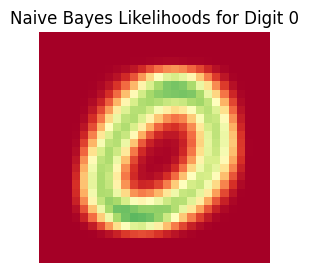

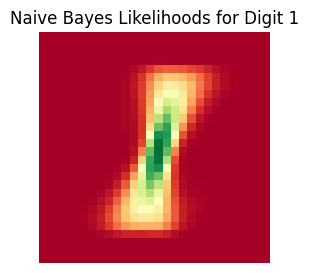

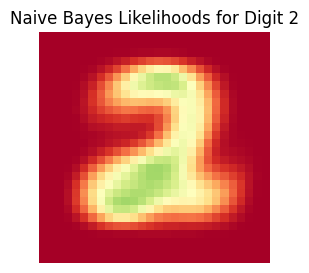

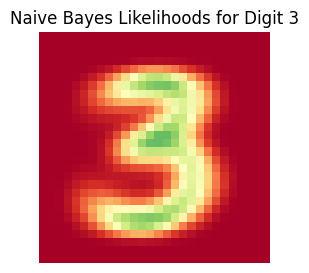

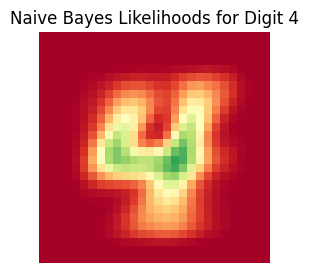

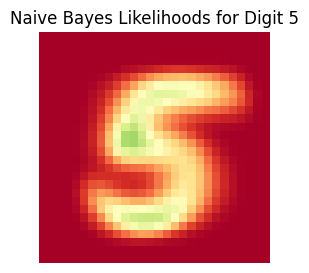

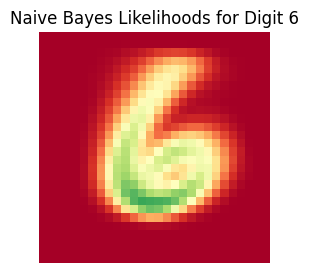

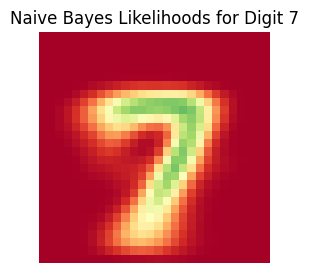

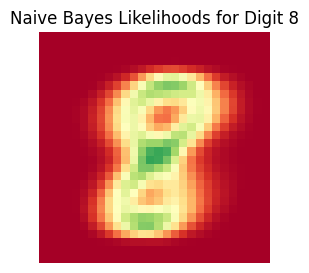

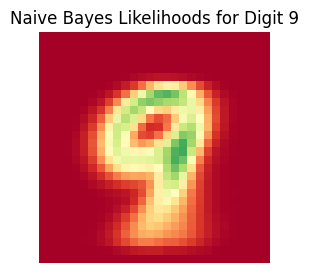

In [13]:
#@title Bayes probability maps
#@markdown Red represents a pixel being unlikely for that digit and green is likely for that digit
import matplotlib.pyplot as plt
import numpy as np
import naive_bayes

(X_train, y_train), (X_test, y_test) = utils.load_and_split_mnist("MNIST")
X_train = (X_train > .5)
X_test = (X_test > .5)

total = len(X_train)
counts = np.zeros((10, X_train.shape[1]), dtype=np.int32)
class_counts = np.zeros(10)
for i in range(0 , total):
  c = y_train[i]
  counts[c] += X_train[i]
  class_counts[y_train[i]] += 1

def visualize_digit_likelihoods(probs, digit):
    plt.figure(figsize=(3,3))
    plt.imshow(probs.reshape(28, 28), cmap='RdYlGn', vmin=0, vmax=1)
    plt.title(f"Naive Bayes Likelihoods for Digit {digit}")
    plt.axis('off')
    plt.show()

for c in range(0,10):
  probs = counts[c]/class_counts[c]
  visualize_digit_likelihoods(probs, c)